
Use the Lehman rep package for fast fourier transforms to
solve the self-consistent equations directly at very low temperatures

A large-N Schwinger boson solver based on a forward fixed-point iteration method.

The self-energy of bosons and holons are given by,

   Σ_B(τ) = - γ G_c(τ) * G_h(τ),

   Σ_h(τ) = - G_c(β - τ) * G_b(τ),
   
where the boson and holon Green's function are given by the Dyson equation,

   G_B(iωₙ) = 1/(iνₙ - λ - Σ_B(iνₙ))

   G_h(iωₙ) = 1/(-1/J_K - Σ_h(iνₙ))

Furthermore, we need to enforce the Lagrange multiplier constraint, such that the
boson occupation number is maintained at q= 2S/N (a pre-defined and constant scalar).
This leads to 

n_b(λ) = G_b (τ = 0-) = q

Therefore, one needs to find the correct λ to satisfy this.

We solve the Dyson equation self-consistently by a weighted fixed point iteration, 
with weight `mix` assigned to the new iterate and weight `1-mix` assigned to the previous iterate. 
mix can be rather big for this non-critical system.
 
The self-energy is evaluated in the imaginary time domain, 
and the Dyson equation is solved in the Matsubara frequency domain.

Note that an alternate notebook can be written through the GreenFunc.jl package.


Important links as I write this code.

https://numericaleft.github.io/Lehmann.jl/dev/lib/spectral/ 

https://arxiv.org/pdf/2107.13094.pdf

https://en.wikipedia.org/wiki/Matsubara_frequency



**This is a list of the items to be implemented on this notebook**

- [X] Write a correct root finder solution to \lambda in order to implement the constraint
- [X] Stabilize the self-energy loop
- [ ] Create a function that solves the self-energy equations and returns Gh and GB for a given \beta
- [ ] Create a check function that finds the self-energies after the loop from G and the self-energies from the equations, and compares the two
- [ ] Feed in any conduction electron's Green's function (from the Green Func package) to solve the impurity problem. 
- [ ] Measurements based on these obtaines green's functions, as a check of whether we are correctly solving the problem. Holon phase shift, spin susceptibility, ...
- [ ] This may require analytic continuation to order G(\omega). Is this avoidable?

In [86]:
using Lehmann
using Printf
using Roots

diff(a, b) = maximum(abs.(a - b)) # return the maximum deviation between a and b
diff_modulated(a, b) = sum(abs.(a - b)) /sum(abs.(b)) # return the maximum deviation between a and b

# Initialize DLR grid
rtol = 1e-10
β = 300.0  #inverse temperature
Euv = 1000 #UV cutoff
df = DLRGrid(Euv = Euv, β = β, isFermi = true, rtol = rtol, symmetry = :none) #fermionic DLR grid
db = DLRGrid(Euv = Euv, β = β, isFermi = false, rtol = rtol, symmetry = :none) #bosonic DLR grid

G_B = zeros(ComplexF64, length(db))
G_h = zeros(ComplexF64, length(df))
G_B_new = zeros(ComplexF64, length(db))
G_h_bar_new = zeros(ComplexF64, length(df))
Sigma_B = zeros(ComplexF64, length(db)) 
Sigma_h = zeros(ComplexF64, length(df))
#some small broadening at the beginning is necessary
#Sigma_B = 1im*eta*ones(ComplexF64, length(db)) 
#Sigma_h = 1im*eta*ones(ComplexF64, length(df))

D = 20  #the half electronic bandwidth, needs to be smaller than Euv
ρ = 1/(2*D)
#below is the conduction electron bandwidth - this could be changed to be more "realistic"
G_c_matfreq = - ρ .* log.( (D .- df.ωn * 1im) ./ (- D .- df.ωn * 1im))
G_c = matfreq2tau(df, G_c_matfreq)

q0 = 0.5 # q0 = 2S/N
γ = q0  # γ ≠ q0 means a under or over screened Kondo model 
λ = (1/β) * log(1/q0 +1) #initial λ for the loop
β_K = 50  #Kondo temperature, used to define J_K, needs to be larger than initial β
J_K = 1 / ρ / log(D * β_K) #alternatively, J_K could be defined by itself

#initialize G_B and G_h with their broadening factors.
#G_B = G_B .+ 1 ./(db.ωn * 1im .- λ + )
#G_h = G_h .- J_K #this is the initial value
Sigma_B_matfreq = tau2matfreq(db, Sigma_B)
Sigma_h_matfreq = tau2matfreq(df, Sigma_h)
#G_B_new = 1 ./(db.ωn * 1im .- λ .- 1im*eta*ones(ComplexF64, length(db)) ) #in omega freq
#initial guesses
G_B_new = G_B_new + 1 ./(db.ωn * 1im .- λ) #in omega freq
G_h_bar_new = G_h_bar_new  #this is the non instantaneous contribution 
#we will bring the instantaneous part of it back later 
#separating it this way helps dlr converge its interpolation
#------
#change initial G_B and G_h to τ format
G_B = G_B + matfreq2tau(db, G_B_new)
G_h = G_h + matfreq2tau(df, G_h_bar_new)

#get nb from the self-energy for the Schwinger bosons
#which constructs the Green's function and finds n_b
function nB_from_Σ(sigmaB, dfreq, x)
   #feed in the freq. valued green's function
   new_Gfunc = 1.0 ./(dfreq.ωn * 1im .- x .- sigmaB)
   all_G_tau_dlr = matfreq2tau(dfreq, new_Gfunc) #last element is G(τ = 0-)
   return -real(all_G_tau_dlr[end])
end

#update the Lagrange multiplier. 
function update_Lagrange(sigmaB, dfreq, q0)
   #define the function for which the root needs to be found
   f(x) = q0 - nB_from_Σ(sigmaB, dfreq, x) 
   #x is positive to enforce the λ_eff (n_b - q) constraint
   # and we have λ_eff = λ + x + Re(Σ_B(0)) > 0
   #this sets λmin, to which we add a small shift
   λmin_theo = - real(Sigma_B_matfreq[searchsorted(db.n,0)][1])
   #find good λmin
   l_list = λmin_theo .+ 10 .^ (-12:0.5:2);
   λmin = l_list[argmin(f.(l_list))]
   #find the zero of f(x) within the (λmin, Euv) region
   #methods:
   #-=-=-=-=
   #use the bisection method
   xval = find_zero(f, (λmin, Euv), atol=1e-6)
   #use the method of closest
   #xval = find_zero(f, λmin, atol=1e-6)
   #Newton's method
   return xval
end

#plot sanity check
#using Plots
#plot(df.τ, real.(G_c))

#sure, the λ you posit is right, but might as well check that
#--
#find the initial root. x is such that λ_tot = λ + x
λ = update_Lagrange(Sigma_B_matfreq, db, q0) 
#println("Initial Lagrange multiplier: $((λ + xval)), x=$xval and n_b - q = $(f(xval))")
#G_B_new = 1 ./(db.ωn * 1im  .- λ .- xval) #in omega freq
#G_B = matfreq2tau(db, G_B_new); #in τ space


0.0036620395532788496

In [48]:
q0 - nB_from_Σ(Sigma_B_matfreq, db, 0.0036620395532788496) 

-3.715635904510961e-7

In [3]:
function solve_self_energy_conditions(G_B, db, G_h, G_c, df, q0, J_K, mix = 0.1, maxiter = 1000)
   #green's functions are fed in imaginary time G(τ)
   numprint = 100
   sumrule = nothing
   verbose = true
   tol = -maximum([-df.rtol * 10, -db.rtol * 10])
   #tol = 1e-5

   #conduction electron G does not change
   tau_c = df.τ # DLR imaginary time nodes
   tau_c_rev = df.β .- tau_c # Reversed imaginary time nodes
   G_c_rev = tau2tau(df, G_c, tau_c_rev) # G_c at beta - tau_k
   
   cont = 1
   iter = 1
   while cont == 1
      #old green's functions
      G_B_old = G_B
      G_h_old = G_h
      #self energy equations in τ
      Sigma_B = - q0 .* G_h .* G_c  #only use dynamic part of G_h - note that γ = q0 is set for exact screening
      #only gives dynamic part of Sigma_B
      Sigma_h = G_B .* G_c_rev
      #their ωn counterparts
      Sigma_B_matfreq = tau2matfreq(db, Sigma_B)
      Sigma_h_matfreq = tau2matfreq(df, Sigma_h)
      
      #define new G_B and G_h in ωn using the self-energy
      #1)
      #solve the Lagrange multiplier constraint with new G_B 
      λ = update_Lagrange(Sigma_B_matfreq, db, q0)
      
      #2) create the new GB and Gh
      G_B_new = 1 ./(db.ωn * 1im .- λ .- Sigma_B_matfreq)
      G_h_new = Sigma_h_matfreq ./((- 1 ./J_K ) .- Sigma_h_matfreq) ./(- 1 ./J_K ) #only the dynamic part
      #convert them to τ space
      G_B_new_tau = matfreq2tau(db, G_B_new)
      G_h_new_tau = matfreq2tau(df, G_h_new)
      
      #mix old and new solutions together 
      G_B = mix * G_B_new_tau + (1 - mix) * G_B_old # Linear mixing
      G_h = mix * G_h_new_tau + (1 - mix) * G_h_old # Linear mixing
   
      dist_GB = diff_modulated(G_B, G_B_new_tau)
      dist_Gh = diff_modulated(G_h, G_h_new_tau)
   
      if sqrt(dist_GB^2 + dist_Gh^2) < tol || iter > maxiter
         cont = 0
      end
   
      if verbose && iter % (maxiter / numprint) == 0
         #println("round $iter: change B $(diff(G_B_old, G_B)) change χ $(diff(G_h_old, G_h))")
         println("round $iter: change B $dist_GB change χ $dist_Gh")
         println("Lagrange multiplier: $(λ) and n_b - q = $(f(λ))")
         println(" ")
         flush(stdout)
      end
   
      iter += 1
   
   end

   return G_B, G_h, λ, Sigma_B_matfreq, Sigma_h_matfreq
end

solve_self_energy_conditions (generic function with 3 methods)

In [4]:
G_B, G_h, λ, Sigma_B_matfreq, Sigma_h_matfreq = solve_self_energy_conditions(G_B, db, G_h, G_c, df, q0, J_K)

ArgumentError: ArgumentError: The interval [a,b] is not a bracketing interval.
You need f(a) and f(b) to have different signs (f(a) * f(b) < 0).
Consider a different bracket or try fzero(f, c) with an initial guess c.



In [87]:
#iteration process
#needs to be put into a function
mix = 0.05
maxiter = 1000
numprint = 50
sumrule = nothing
verbose = true
#tol = -maximum([-df.rtol * 10, -db.rtol * 10])
tol = 1e-2
println("tolerance that you seek: $tol")

#conduction electron G does not change
tau_c = df.τ # DLR imaginary time nodes
tau_c_rev = df.β .- tau_c # Reversed imaginary time nodes
G_c_rev = tau2tau(df, G_c, tau_c_rev) # G_c at beta - tau_k

cont = 1
iter = 1
while cont == 1
   #old green's functions
   G_B_old = G_B
   G_h_old = G_h
   #self energy equations in τ
   Sigma_B = - γ .* G_h .* G_c  #only use dynamic part of G_h
   #only gives dynamic part of Sigma_B
   Sigma_h = G_B .* G_c_rev
   #their ωn counterparts
   Sigma_B_matfreq = tau2matfreq(db, Sigma_B)
   Sigma_h_matfreq = tau2matfreq(df, Sigma_h)
   
   #define new G_B and G_h in ωn using the self-energy
   #1)
   #solve the Lagrange multiplier constraint with new G_B 
   λ = update_Lagrange(Sigma_B_matfreq, db, q0)
   
   #2) create the new GB and Gh
   G_B_new = 1 ./(db.ωn * 1im .- λ .- Sigma_B_matfreq)
   G_h_new = Sigma_h_matfreq ./((- 1 ./J_K ) .- Sigma_h_matfreq) ./(- 1 ./J_K ) #only the dynamic part
   #convert them to τ space
   G_B_new_tau = matfreq2tau(db, G_B_new)
   G_h_new_tau = matfreq2tau(df, G_h_new)
   
   #mix old and new solutions together 
   G_B = mix * G_B_new_tau + (1 - mix) * G_B_old # Linear mixing
   G_h = mix * G_h_new_tau + (1 - mix) * G_h_old # Linear mixing

   dist_GB = diff_modulated(G_B, G_B_new_tau)
   dist_Gh = diff_modulated(G_h, G_h_new_tau)

   if sqrt(dist_GB^2 + dist_Gh^2) < tol || iter > maxiter
      cont = 0
   end

   if verbose && iter % (maxiter / numprint) == 0
      #println("round $iter: change B $(diff(G_B_old, G_B)) change χ $(diff(G_h_old, G_h))")
      println("round $iter: change B $dist_GB change χ $dist_Gh")
      println("Lagrange multiplier times β: $(λ) and n_b - q = $(q0 - nB_from_Σ(Sigma_B_matfreq, db, λ))")
      println(" ")
      flush(stdout)
   end

   iter += 1

end

println("done in $iter steps")

tolerance that you seek: 0.01


round 20: change B 0.0056894855411071645 change χ 0.3586884476780579
Lagrange multiplier times β: -0.27497807840564786 and n_b - q = -4.049004032058434e-8
 


round 40: change B 0.004265348961183656 change χ 0.1289806664962308
Lagrange multiplier times β: -0.3838630935894382 and n_b - q = -1.1340012484595263e-7
 


round 60: change B 0.0027411295760587143 change χ 0.04664661698338124
Lagrange multiplier times β: -0.42336424856790444 and n_b - q = -8.783225392550165e-7
 


round 80: change B 0.000957802327682845 change χ 0.017065518656190184
Lagrange multiplier times β: -0.43787216899120956 and n_b - q = 3.3268557536603183e-7
 


done in 92 steps


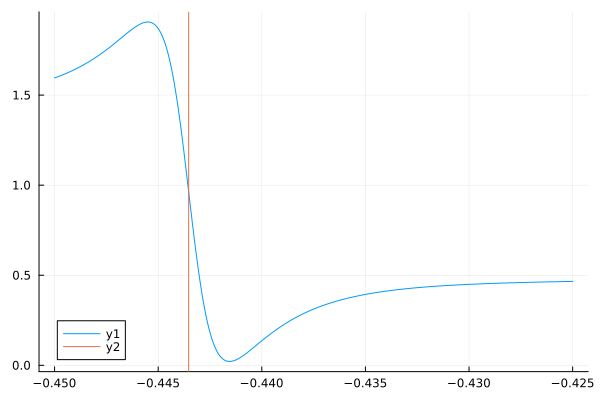

In [56]:
f(x) = q0 - nB_from_Σ(Sigma_B_matfreq, db, x)

λmin_theo = - real(Sigma_B_matfreq[searchsorted(db.n,0)][1])

xval = -0.450:0.00001:-0.425
plot(xval, f.(xval))
vline!([λmin_theo])

In [31]:
#phase shift calculation - does not seem good
G_h_omega = tau2matfreq(df, G_h)
Sigma_h_one = matfreq2tau(df, - ((1.0 ./ G_h_omega) .- (- 1 ./J_K )))
Sigma_h_two = G_B .* G_c_rev
delta1 = -imag(log(J_K - sum(Sigma_h_two)/β))/π
#delta1 = imag(log(sum(G_h)/β))/π

7.760601052029793e-5

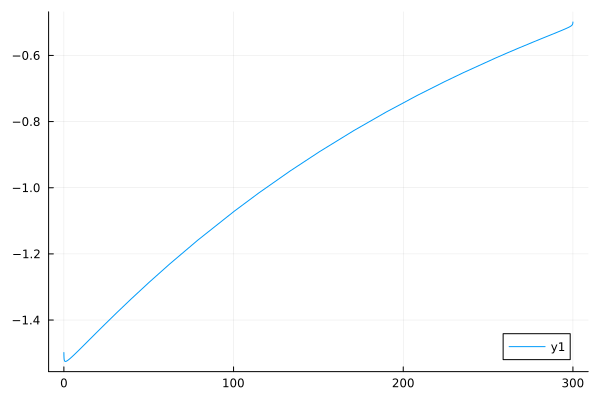

In [89]:
plot(db.τ, real(G_B))

In [235]:
function calculate_local_spin_susceptibility(G, β)
    #this takes in a G in τ space
    chi = sum(G.^2) ./β
    
    return real(chi)
end

calculate_local_spin_susceptibility (generic function with 2 methods)

In [236]:
calculate_local_spin_susceptibility(G_B, β)

2.1921420328752745

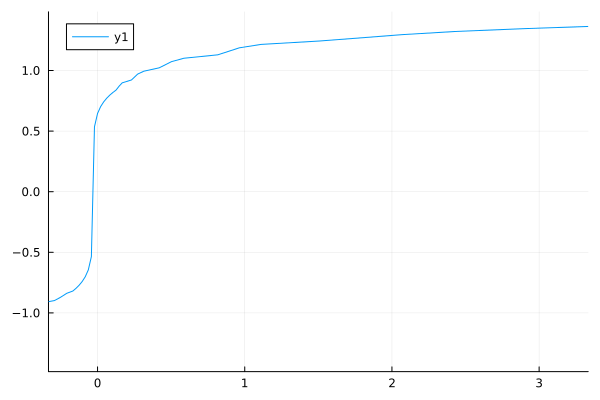

In [98]:
Gplot = tau2matfreq(df, G_h)
#plot(df.ωn, imag(Gplot), xscale=:log, xlim=(1e-2,5000))
plot(db.ωn, imag(Gplot), xlim=(-100/β, 1000/β))

In [ ]:
db.ωn

In [85]:
#visualization of lambda min and the process
f(x) = q0 - nB_from_Σ(Sigma_B_matfreq, db, x)
lmin = -λ - real(Sigma_B_matfreq[searchsorted(db.n,0)][1])
x = lmin:0.01:1
plot(x, f.(x))
vline!([lmin])

5-element Vector{Float64}:
 -0.3141592653589793
 -0.18849555921538758
 -0.06283185307179587
  0.06283185307179587
  0.18849555921538758

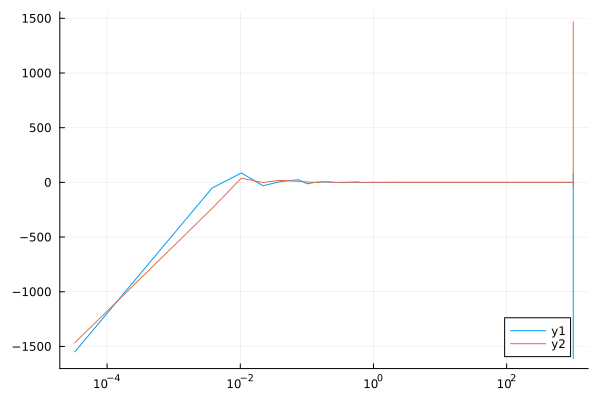

In [34]:
plot(df.τ, imag(G_h), xscale=:log10)
plot!(df.τ, real(G_h),xscale=:log10)

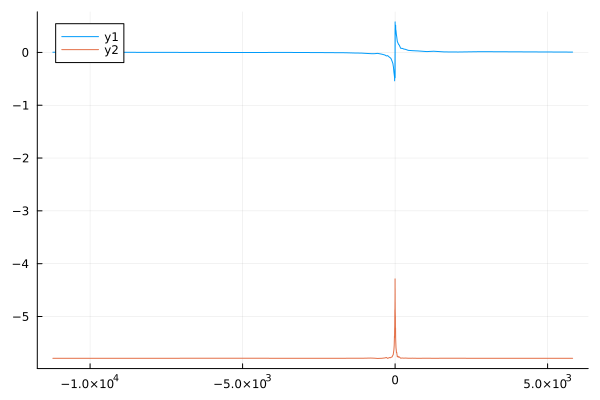

In [61]:
G_h_omega = tau2matfreq(df, G_h)
plot(df.ωn, imag(G_h_omega))
plot!(df.ωn, real(G_h_omega))


In [3]:
#test if the solutions work

#first version of Self energies
G_B_omega = tau2matfreq(db, G_B)
Sigma_B_one = matfreq2tau(db, - ((1.0 ./ G_B_omega) .- db.ωn * 1im .+ λ .+ xval))
G_h_omega = tau2matfreq(df, G_h)
Sigma_h_one = matfreq2tau(df, - ((1.0 ./ G_h_omega) .- (- 1 ./J_K )))

#conduction electron G does not change
Sigma_B_two = - γ .* G_h .* G_c
Sigma_h_two = G_B .* G_c_rev


println("check: Σ(1)_B - Σ(2)_B $(diff_modulated(Sigma_B_two, Sigma_B_one)) Σ(1)_χ - Σ(2)_χ $(diff_modulated(Sigma_h_two, Sigma_h_one))")

check: Σ(1)_B - Σ(2)_B 8.761665459522396e-6 Σ(1)_χ - Σ(2)_χ 3.410009317276392e-7


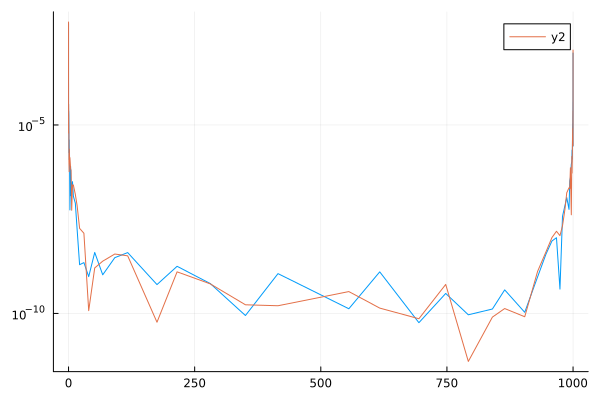

In [4]:
using Plots
plot(db.τ, abs.(imag(Sigma_B_one) - imag(Sigma_B_two)), yscale=:log10, label="")
plot!(db.τ, abs.(real(Sigma_B_one) - real(Sigma_B_two)), yscale=:log10)